**Libraries**


In [1]:
# Standard Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pandas as pd

# Scikit-Learn Utilities
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# TensorFlow and Keras Core Modules
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

# Pretrained Models from Keras Applications
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input

# Data Preparation and Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Rescaling



**Mounting Drive & Defining Paths**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = "/content/drive/MyDrive/LungCancer"
print("Contents of LungCancer:", os.listdir(data_dir))

Contents of LungCancer: ['benign', 'squamous_cell_carcinoma', 'adenocarcinoma']


**Splitting Dataset Into Train & Validation & Test Sets**

In [5]:
# Path to the dataset
dataset_path = "/content/drive/MyDrive/LungCancer"  # Main folder 'LungCancer'
output_path = "/content/drive/MyDrive/LungCancerSplit"  # Where splits will be stored

# Classes (subfolders)
classes = ['squamous_cell_carcinoma', 'benign', 'adenocarcinoma']

# Create output directories
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(output_path, split, cls), exist_ok=True)

# Split and copy images
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)

    # Split the images
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Convert to sets to check for uniqueness
    assert len(set(train_imgs) & set(val_imgs)) == 0, "Train and Validation sets have duplicates!"
    assert len(set(train_imgs) & set(test_imgs)) == 0, "Train and Test sets have duplicates!"
    assert len(set(val_imgs) & set(test_imgs)) == 0, "Validation and Test sets have duplicates!"

    print(f"Class '{cls}' - No duplicates found between splits.")

    # Copy to respective directories
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_path, 'train', cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_path, 'val', cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_path, 'test', cls, img))

print("Dataset split into train, validation, and test sets successfully! All splits are unique.")

Class 'squamous_cell_carcinoma' - No duplicates found between splits.
Class 'benign' - No duplicates found between splits.
Class 'adenocarcinoma' - No duplicates found between splits.
Dataset split into train, validation, and test sets successfully! All splits are unique.


**Verifying Images Counts In The Train & Validation & Test And Their Classes**

In [6]:
# Path to the main output directory
output_path = "/content/drive/MyDrive/LungCancerSplit"    # Replace with your output directory

# Function to count images in each folder
def count_images_in_folders(root_path):
    for split in ['train', 'val', 'test']:  # Loop through train, val, test
        print(f"\n--- {split.upper()} SET ---")
        split_path = os.path.join(root_path, split)

        # Loop through each class folder
        for cls in os.listdir(split_path):
            class_path = os.path.join(split_path, cls)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                print(f"Class '{cls}': {num_images} images")

# Run the function
count_images_in_folders(output_path)


--- TRAIN SET ---
Class 'squamous_cell_carcinoma': 3500 images
Class 'benign': 3500 images
Class 'adenocarcinoma': 3500 images

--- VAL SET ---
Class 'squamous_cell_carcinoma': 750 images
Class 'benign': 750 images
Class 'adenocarcinoma': 750 images

--- TEST SET ---
Class 'squamous_cell_carcinoma': 750 images
Class 'benign': 750 images
Class 'adenocarcinoma': 750 images


**Data Loading & Preprocessing & Augmentation**

In [7]:
train_dir = "/content/drive/MyDrive/LungCancerSplit/train"
val_dir = "/content/drive/MyDrive/LungCancerSplit/val"
test_dir = "/content/drive/MyDrive/LungCancerSplit/test"

# Training data generator (with augmentations)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,           # Random rotation
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Random zoom
    horizontal_flip=True,        # Horizontal flipping
    fill_mode='nearest',         # Filling strategy for new pixels
)

# Validation and Test data generator (no augmentations)
val_test_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),     # Resize images to 150x150
    batch_size=32,              # Batch size
    class_mode='categorical',   # Multi-class classification
    shuffle=True                # Shuffle training data
)

# Validation generator
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),     # Resize images to 150x150
    batch_size=32,              # Batch size
    class_mode='categorical',   # Multi-class classification
    shuffle=False               # Do not shuffle validation data
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),     # Resize images to 150x150
    batch_size=32,              # Batch size
    class_mode='categorical',   # Multi-class classification
    shuffle=False               # Do not shuffle test data
)

# Display class indices for reference
print("Class Indices:", train_generator.class_indices)

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Class Indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}


**Sample Image From Each Class**

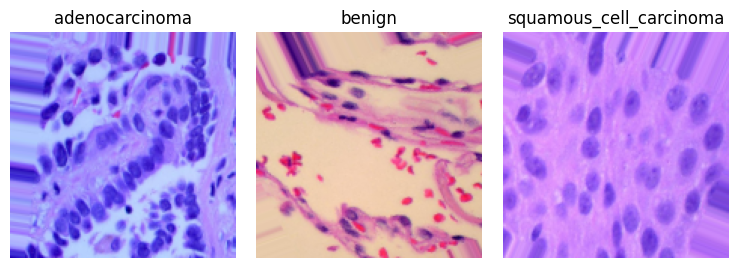

In [ ]:
# Get class names from the train_generator
class_names = list(train_generator.class_indices.keys())

# Create a figure for plotting
plt.figure(figsize=(10, 10))

# Iterate through each class
for i, class_name in enumerate(class_names):
    # Reset the generator to ensure we can iterate through all images
    train_generator.reset()

    # Loop through the batches in the generator
    for images, labels in train_generator:
        # Find the index of the first occurrence of the current class
        for j in range(len(labels)):
            if np.argmax(labels[j]) == i:  # Check if the label matches the class index
                # Plot the first image of this class
                plt.subplot(4, 4, i + 1)  # Adjust grid size based on number of classes
                plt.imshow(images[j])
                plt.title(class_name)
                plt.axis("off")
                break
        else:
            continue
        break

# Show the plot with one image from each class
plt.tight_layout()
plt.show()


**Resnet50 Model**

In [8]:
# Load the ResNet50 base model with pretrained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Dropout for regularization
predictions = Dense(3, activation='softmax')(x)  # Final layer with 3 classes 

# Create the final model
ResNet_model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the top 30 layers of the base model for fine-tuning
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially
for layer in base_model.layers[-30:]:
    layer.trainable = True  # Unfreeze the last 30 layers


# Define optimizer
optimizer = Adam(learning_rate=0.0001)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=5,                 # Stop if no improvement for 5 epochs
    restore_best_weights=True   # Restore model weights from the epoch with the best validation loss
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',         # Monitor validation loss
    factor=0.1,                 # Reduce learning rate 
    patience=3,                 # Wait for 3 epochs with no improvement before reducing learning rate
    min_lr=1e-6,                # Set a floor for the learning rate
    verbose=1                   # Display learning rate updates
)
# CSV Logger
csv_logger = CSVLogger(
    filename='training_ResNet50_log_v2.csv',
    append=True
)
callbacks = [
    lr_scheduler,
    early_stopping,
    csv_logger
]

# Compile the model
ResNet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
ResNet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,212,227 (99.99 MB)

 Trainable params: 17,074,691 (65.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

**Train The Model**

In [9]:
# Train the model
ResNet50_history = ResNet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,                  # Total epochs
    callbacks=callbacks # Include all defined callbacks
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 170s 436ms/step - accuracy: 0.6572 - loss: 0.7199 - val_accuracy: 0.4160 - val_loss: 1.9012 - learning_rate: 1.0000e-04
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 126s 376ms/step - accuracy: 0.8134 - loss: 0.4268 - val_accuracy: 0.5329 - val_loss: 1.2461 - learning_rate: 1.0000e-04
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 123s 367ms/step - accuracy: 0.8371 - loss: 0.3837 - val_accuracy: 0.7467 - val_loss: 0.5944 - learning_rate: 1.0000e-04
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 122s 365ms/step - accuracy: 0.8521 - loss: 0.3539 - val_accuracy: 0.4689 - val_loss: 2.2892 - learning_rate: 1.0000e-04
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 121s 361ms/step - accuracy: 0.8601 - loss: 0.3387 - val_accuracy: 0.8440 - val_loss: 0.3680 - learning_rate: 1.0000e-04
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 123s 367ms/step - accuracy: 0.8682 - loss: 0.3217 - val_accuracy: 0.6502 - val_loss: 1.2179 - learning_rate: 1.0000e-04
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 121s 360ms/

**Training and Validation Plot**

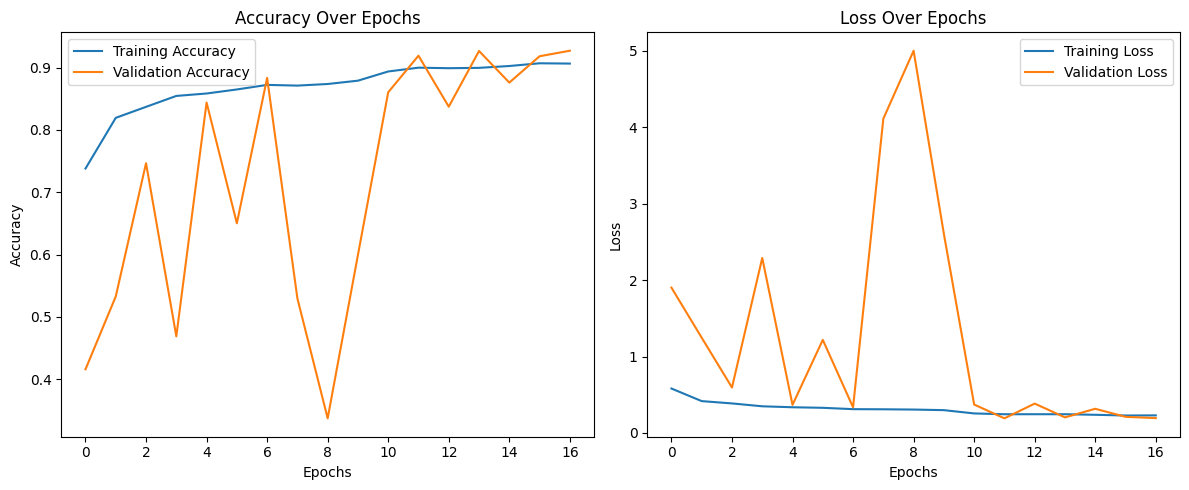

In [13]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(ResNet50_history.history['accuracy'], label='Training Accuracy')
plt.plot(ResNet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(ResNet50_history.history['loss'], label='Training Loss')
plt.plot(ResNet50_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Accuracy On The Test Set (Unseen Data)**

In [14]:
test_loss, test_accuracy = ResNet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Validation Loss: {test_loss:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.8600 - loss: 0.2927
Test Accuracy: 91.02%
Validation Loss: 0.2055


**Save The ResNet50 Model**

In [15]:
ResNet50_model_save_path = '/content/drive/MyDrive/LungCancer_ResNet50_model_v2.h5'
ResNet_model.save(ResNet50_model_save_path)
print(f"VGG Model saved to {ResNet50_model_save_path}")

from google.colab import files
files.download(ResNet50_model_save_path)

VGG Model saved to /content/drive/MyDrive/LungCancer_ResNet50_model_v2.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**InceptionV3 Model**

In [16]:
# Load the InceptionV3 base model with pretrained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Dropout for regularization
predictions = Dense(3, activation='softmax')(x)  # Final layer with 3 classes 

# Create the final model
InceptionV3_model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the top 30 layers of the base model for fine-tuning
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially
for layer in base_model.layers[-30:]:
    layer.trainable = True  # Unfreeze the last 30 layers

# Define optimizer
optimizer = Adam(learning_rate=0.0001)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=5,                 # Stop if no improvement for 5 epochs
    restore_best_weights=True   # Restore model weights from the epoch with the best validation loss
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',         # Monitor validation loss
    factor=0.1,                 # Reduce learning rate 
    patience=3,                 # Wait for 3 epochs with no improvement before reducing learning rate
    min_lr=1e-6,                # Set a floor for the learning rate
    verbose=1                   # Display learning rate updates
)

# CSV Logger
csv_logger = CSVLogger(
    filename='training_InceptionV3_log_v2.csv',
    append=True
)

callbacks = [
    lr_scheduler,
    early_stopping,
    csv_logger
]

# Compile the model
InceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
InceptionV3_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 24,427,299 (93.18 MB)

 Trainable params: 7,780,547 (29.68 MB)

 Non-trainable params: 16,646,752 (63.50 MB)

**Train The Model**

In [17]:
# Train the model
InceptionV3_history = InceptionV3_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,                  # Total epochs
    callbacks=callbacks         # Include all defined callbacks
)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 162s 424ms/step - accuracy: 0.8036 - loss: 0.4534 - val_accuracy: 0.9440 - val_loss: 0.1416 - learning_rate: 1.0000e-04
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 120s 358ms/step - accuracy: 0.9207 - loss: 0.2026 - val_accuracy: 0.9596 - val_loss: 0.1040 - learning_rate: 1.0000e-04
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 122s 363ms/step - accuracy: 0.9331 - loss: 0.1732 - val_accuracy: 0.9667 - val_loss: 0.0847 - learning_rate: 1.0000e-04
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 122s 363ms/step - accuracy: 0.9417 - loss: 0.1469 - val_accuracy: 0.9636 - val_loss: 0.0938 - learning_rate: 1.0000e-04
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 121s 361ms/step - accuracy: 0.9515 - loss: 0.1207 - val_accuracy: 0.9773 - val_loss: 0.0643 - learning_rate: 1.0000e-04
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 123s 367ms/step - accuracy: 0.9534 - loss: 0.1266 - val_accuracy: 0.9809 - val_loss: 0.0528 - learning_rate: 1.0000e-04
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 

**Training and Validation Plot**

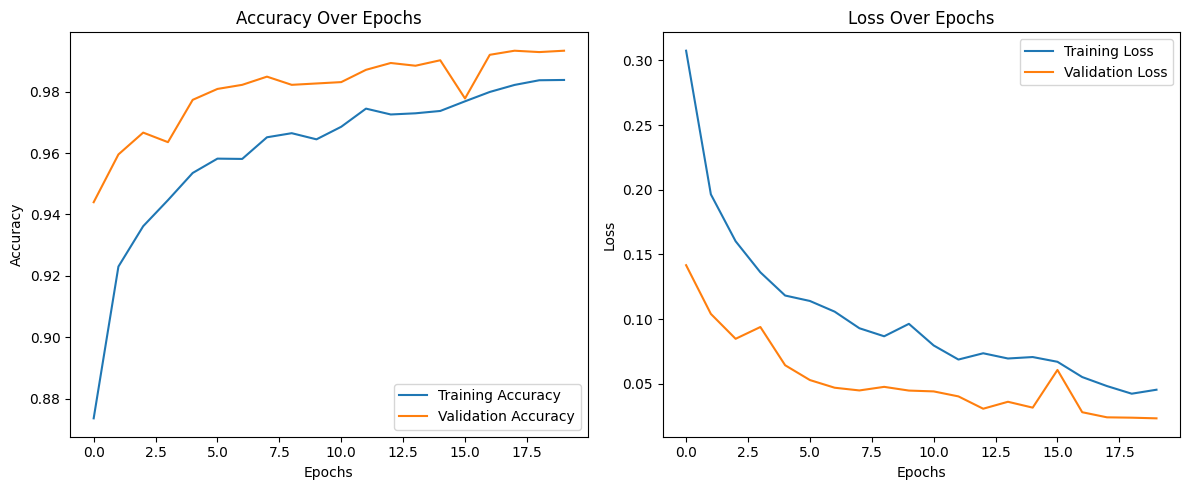

In [18]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(InceptionV3_history.history['accuracy'], label='Training Accuracy')
plt.plot(InceptionV3_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(InceptionV3_history.history['loss'], label='Training Loss')
plt.plot(InceptionV3_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Accuracy On The Test Set (Unseen Data)**

In [19]:
# Evaluate the model on the validation set
val_loss, val_accuracy = InceptionV3_model.evaluate(test_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 0.9892 - loss: 0.0414
Validation Accuracy: 98.89%
Validation Loss: 0.0347


**Save The InceptionV3 Model**

In [20]:
# Save the model
InceptionV3_model_save_path = '/content/drive/MyDrive/LungCancer_InceptionV3_model_v2.h5'
InceptionV3_model.save(InceptionV3_model_save_path)
print(f"InceptionV3 Model saved to {InceptionV3_model_save_path}")

# Download the model
from google.colab import files
files.download(InceptionV3_model_save_path)

InceptionV3 Model saved to /content/drive/MyDrive/LungCancer_InceptionV3_model_v2.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**VGG16 Model**

In [21]:
# Load the VGG16 base model with pretrained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(base_model.output)  # Flatten the feature maps
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Dropout for regularization
predictions = Dense(3, activation='softmax')(x)  # Final layer with 3 classes 

# Create the final model
VGG16_model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially
for layer in base_model.layers[-30:]:
    layer.trainable = True  # Unfreeze the last 30 layers

# Define optimizer
optimizer = Adam(learning_rate=0.0001)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=5,                 # Stop if no improvement for 5 epochs
    restore_best_weights=True   # Restore model weights from the epoch with the best validation loss
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',         # Monitor validation loss
    factor=0.1,                 # Reduce learning rate 
    patience=3,                 # Wait for 3 epochs with no improvement before reducing learning rate
    min_lr=1e-6,                # Set a floor for the learning rate
    verbose=1                   # Display learning rate updates
)

# CSV Logger
csv_logger = CSVLogger(
    filename='training_VGG16_log_v2.csv',
    append=True
)

callbacks = [
    lr_scheduler,
    early_stopping,
    csv_logger
]

# Compile the model
VGG16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
VGG16_model.summary()



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,630,659 (90.14 MB)

 Trainable params: 23,630,659 (90.14 MB)

 Non-trainable params: 0 (0.00 B)

**Train The Model**

In [22]:
# Train the model
VGG16_history = VGG16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,                  # Total epochs
    callbacks=callbacks         # Include all defined callbacks
)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 152s 402ms/step - accuracy: 0.8353 - loss: 0.3869 - val_accuracy: 0.9529 - val_loss: 0.1434 - learning_rate: 1.0000e-04
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 121s 362ms/step - accuracy: 0.9370 - loss: 0.1627 - val_accuracy: 0.9413 - val_loss: 0.1695 - learning_rate: 1.0000e-04
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 121s 362ms/step - accuracy: 0.9524 - loss: 0.1156 - val_accuracy: 0.9756 - val_loss: 0.0613 - learning_rate: 1.0000e-04
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 121s 361ms/step - accuracy: 0.9670 - loss: 0.0965 - val_accuracy: 0.9489 - val_loss: 0.1155 - learning_rate: 1.0000e-04
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 124s 370ms/step - accuracy: 0.9665 - loss: 0.0892 - val_accuracy: 0.9751 - val_loss: 0.0629 - learning_rate: 1.0000e-04
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 124s 371ms/step - accuracy: 0.9749 - loss: 0.0673 - val_accuracy: 0.9924 - val_loss: 0.0275 - learning_rate: 1.0000e-04
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 

**Training and Validation Plot**

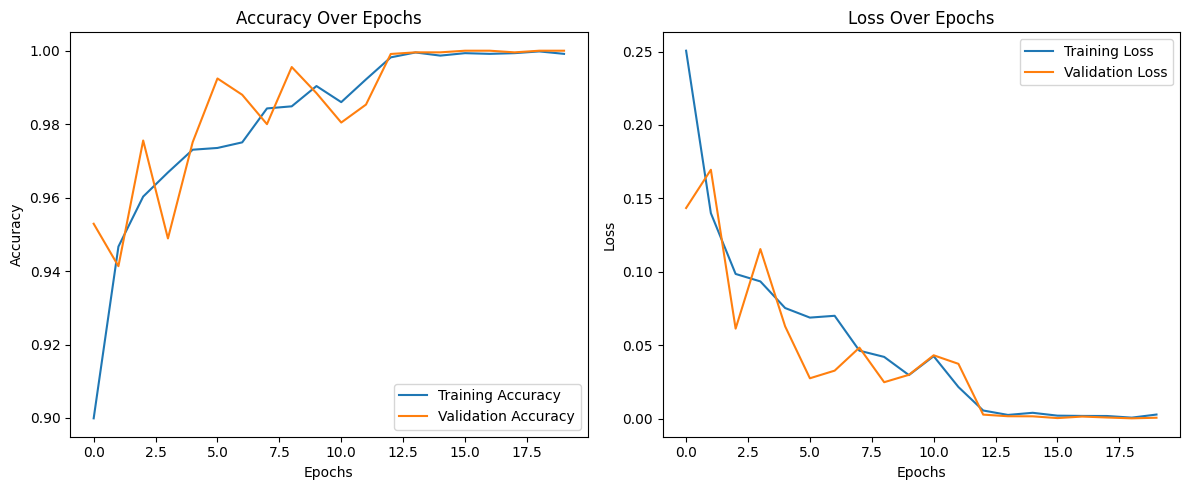

In [23]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(VGG16_history.history['accuracy'], label='Training Accuracy')
plt.plot(VGG16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(VGG16_history.history['loss'], label='Training Loss')
plt.plot(VGG16_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



**Accuracy On The Test Set (Unseen Data)**

In [24]:
# Evaluate the model on the validation set
val_loss, val_accuracy = VGG16_model.evaluate(test_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 1.0000 - loss: 3.6118e-04
Validation Accuracy: 100.00%
Validation Loss: 0.0006


**Save The VGG16 Model**

In [25]:
# Save the model
VGG16_model_save_path = '/content/drive/MyDrive/LungCancer_VGG16_model_v2.h5'
VGG16_model.save(VGG16_model_save_path)
print(f"VGG16 Model saved to {VGG16_model_save_path}")

# Download the model
from google.colab import files
files.download(VGG16_model_save_path)

VGG16 Model saved to /content/drive/MyDrive/LungCancer_VGG16_model_v2.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**CNN Model**

In [26]:
# Define the CNN model
def create_cnn_model():
    model = Sequential([
        # Rescaling layer
        Rescaling(1./255, input_shape=(150, 150, 3)),

        # Convolutional and Pooling layers
        Conv2D(16, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten the feature maps
        Flatten(),

        # Fully connected layers
        Dense(32, activation='relu'),
        Dropout(0.5),  # Dropout for regularization
        Dense(3, activation='softmax')  # Output layer for 3 classes
    ])

    return model

# Create the model
cnn_model = create_cnn_model()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

csv_logger = CSVLogger(
    filename='training_CNN_log_v2.csv',
    append=True
)

callbacks = [early_stopping, lr_scheduler, csv_logger]

# Compile the model
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │         200,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,275 (1.14 MB)

 Trainable params: 298,275 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

**Train The Model**

In [27]:
# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 132s 380ms/step - accuracy: 0.4202 - loss: 1.0563 - val_accuracy: 0.7333 - val_loss: 0.5539 - learning_rate: 1.0000e-04
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 126s 376ms/step - accuracy: 0.6652 - loss: 0.6258 - val_accuracy: 0.7898 - val_loss: 0.4730 - learning_rate: 1.0000e-04
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 123s 366ms/step - accuracy: 0.7258 - loss: 0.5501 - val_accuracy: 0.8080 - val_loss: 0.4418 - learning_rate: 1.0000e-04
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 124s 368ms/step - accuracy: 0.7390 - loss: 0.5292 - val_accuracy: 0.7827 - val_loss: 0.5029 - learning_rate: 1.0000e-04
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 122s 365ms/step - accuracy: 0.7700 - loss: 0.4900 - val_accuracy: 0.8302 - val_loss: 0.4158 - learning_rate: 1.0000e-04
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 124s 370ms/step - accuracy: 0.7902 - loss: 0.4788 - val_accuracy: 0.8667 - val_loss: 0.3592 - learning_rate: 1.0000e-04
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 

**Training and Validation Plot**

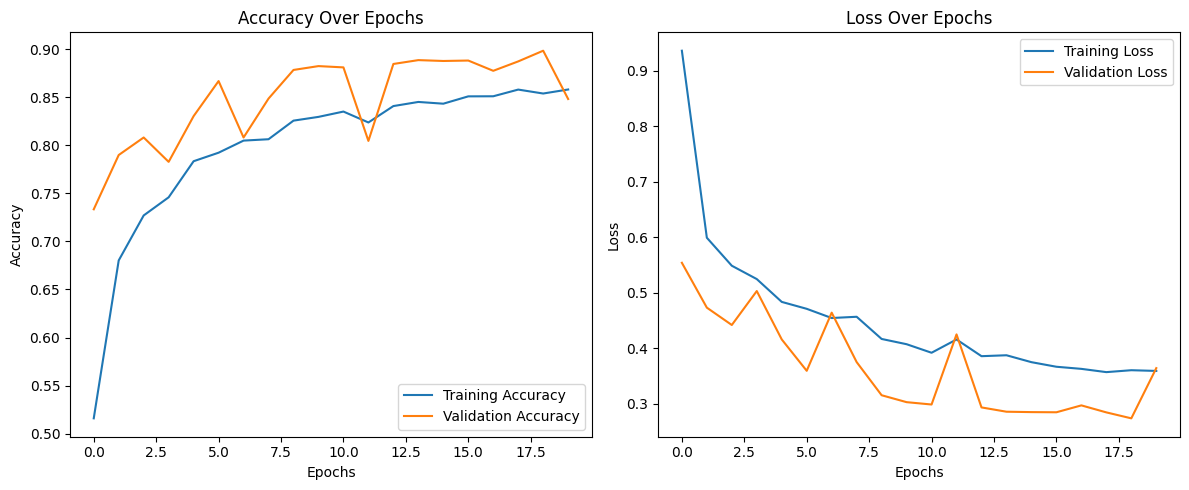

In [28]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Accuracy On The Test Set (Unseen Data)**

In [29]:
# Evaluate the model
val_loss, val_accuracy = cnn_model.evaluate(test_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.8888 - loss: 0.3168
Validation Accuracy: 87.96%
Validation Loss: 0.3015


**Save the CNN Model**

In [30]:
# Save the model
cnn_model_save_path = '/content/drive/MyDrive/LungCancer_CNN_model_v2.h5'
cnn_model.save(cnn_model_save_path)
print(f"CNN Model saved to {cnn_model_save_path}")

# Download the model
from google.colab import files
files.download(cnn_model_save_path)

CNN Model saved to /content/drive/MyDrive/LungCancer_CNN_model_v2.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Compare Models**

         Model  Validation Accuracy (%)  Validation Loss
0        VGG16               100.000000         0.000222
1     ResNet50                91.911113         0.191205
2  InceptionV3                99.333334         0.023207
3   Custom CNN                89.822221         0.273532


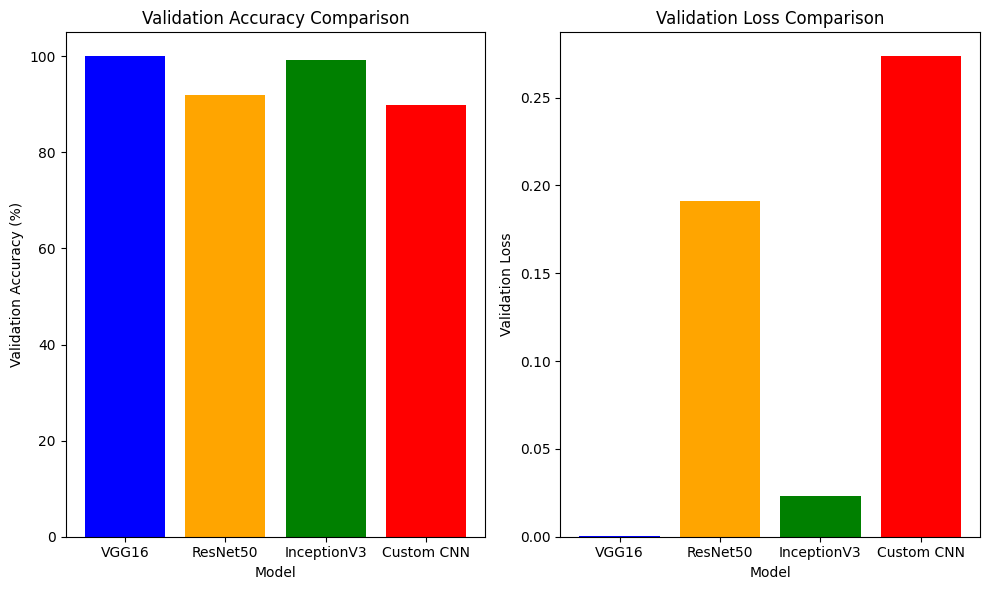

In [31]:
# Define a dictionary to store model performance
model_performance = {
    'Model': [],
    'Validation Accuracy (%)': [],
    'Validation Loss': [],
}

# Evaluate VGG16
vgg16_val_loss, vgg16_val_accuracy = VGG16_model.evaluate(validation_generator, verbose=0)
model_performance['Model'].append('VGG16')
model_performance['Validation Accuracy (%)'].append(vgg16_val_accuracy * 100)
model_performance['Validation Loss'].append(vgg16_val_loss)

# Evaluate ResNet50
resnet50_val_loss, resnet50_val_accuracy = ResNet_model.evaluate(validation_generator, verbose=0)
model_performance['Model'].append('ResNet50')
model_performance['Validation Accuracy (%)'].append(resnet50_val_accuracy * 100)
model_performance['Validation Loss'].append(resnet50_val_loss)

# Evaluate InceptionV3
inceptionv3_val_loss, inceptionv3_val_accuracy = InceptionV3_model.evaluate(validation_generator, verbose=0)
model_performance['Model'].append('InceptionV3')
model_performance['Validation Accuracy (%)'].append(inceptionv3_val_accuracy * 100)
model_performance['Validation Loss'].append(inceptionv3_val_loss)

# Evaluate Custom CNN
cnn_val_loss, cnn_val_accuracy = cnn_model.evaluate(validation_generator, verbose=0)
model_performance['Model'].append('Custom CNN')
model_performance['Validation Accuracy (%)'].append(cnn_val_accuracy * 100)
model_performance['Validation Loss'].append(cnn_val_loss)

# Convert the results to a DataFrame
performance_df = pd.DataFrame(model_performance)

# Display the results in tabular form
print(performance_df)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
plt.bar(performance_df['Model'], performance_df['Validation Accuracy (%)'], color=['blue', 'orange', 'green', 'red'])
plt.title('Validation Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy (%)')

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.bar(performance_df['Model'], performance_df['Validation Loss'], color=['blue', 'orange', 'green', 'red'])
plt.title('Validation Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Loss')

plt.tight_layout()
plt.show()
